In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from tqdm import trange
from dataclasses import dataclass
import csv

In [2]:
from module import *

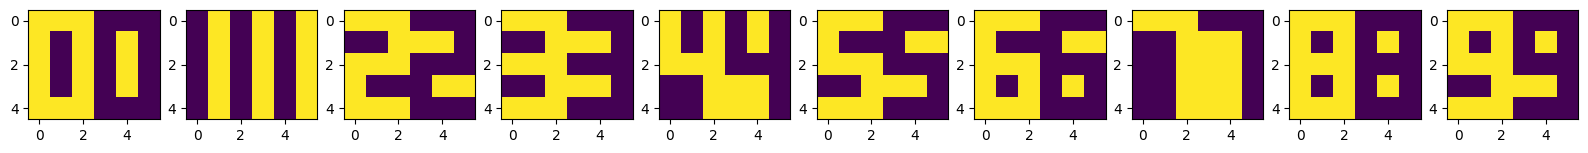

In [3]:
data_rows = {
    "e":  {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1},
    "r":  {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0},
    "c":  {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1},
    "cr": {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0},
    "l":  {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1},
    "lr": {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0},
    "lc": {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1},
    "f":  {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0},
    "off":{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
}
numbers = {
    0: "f lr lr lr f",
    1: "c c c c c",
    2: "f r f l f",
    3: "f r f r f",
    4: "lr lr f r r",
    5: "f l f r f",
    6: "f l f lr f",
    7: "f r r r r",
    8: "f lr f lr f",
    9: "f lr f r f",
}
empty = np.array([[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1]])

numbers_rows = {k: [data_rows[vv] for vv in v.split(" ")] for k, v in numbers.items()}

fig, axs = plt.subplots(1, 10, figsize=(20,20))
for ax, n in zip(axs, numbers_rows.values()):
    ax.imshow(pd.DataFrame(n).values)

In [4]:
def draw_network(net):
    import networkx as nx
    edges = []
    pos = {}
    n_in = {}
    for node, (_, priority, listen, cast, __) in net.nodes.iterrows():
        if listen is not None:
            try:
                iter(listen)
            except:
                listen = [listen]
            for l in listen:
                edges.append((l, node))
        if cast is not None:
            try:
                iter(cast)
            except:
                cast = [cast]
            for c in cast:
                edges.append((node, c))
        if priority not in n_in:
            n_in[priority] = 0
        pos[node] = (priority, n_in[priority])
        n_in[priority] += 0.5
    G = nx.DiGraph()
    G.add_edges_from(edges)
    plt.figure(figsize=(15,15))
    options = {
        "font_size": 12,
        "node_size": 300,
        "node_color": "white",
        "edgecolors": "blue",
        "linewidths": 2,
        "width": 2,
        "connectionstyle": 'arc3, rad = 0.3'
    }
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    nx.draw_networkx(G, pos, **options)
    plt.show()

In [5]:
params_rows = {
    "tau_leak": 1, 
    "tau_inhibitory": 10,
    "tau_refractory": 10,
    "tau_ltp": 1, 
    "thres": 750,
    "ainc": 30, 
    "adec": -15, 
    "wmax": 255, 
    "wmin": 1,
    "learning": False
}
weights_rows = np.array([
    [1, 1, 1, 255, 255, 255],
    [1, 1, 255, 255, 255, 1],
    [1, 255, 1, 255, 1, 255],
    [1, 255, 255, 255, 1, 1],
    [255, 1, 1, 1, 255, 255],
    [255, 1, 255, 1, 255, 1],
    [255, 255, 1, 1, 1, 255],
    [255, 255, 255, 1, 1, 1]
])
labels_rows = [
    "e",
    "r",
    "c",
    "cr",
    "l",
    "lr",
    "lc",
    "f"
]
params_digits = {
    "tau_leak": 50, 
    "tau_inhibitory": 30, 
    "tau_refractory": 300,
    "tau_ltp": 50 ,
    "thres": 500,
    "ainc": 20, 
    "adec": -15, 
    "wmax": 255, 
    "wmin": 1,
    "learning": True,
    "wta": True
}
weights_digits = np.array([
    [1, 1, 255, 1, 1, 1, 1, 1],
    [1, 255, 1, 1, 255, 1, 1, 255],
    [1, 1, 1, 1, 1,255, 1, 255]
])
labels_digits = [
    "one",
    "two",
    "zero"
]
net = SpikeNetworkSim(inputs_l=6, dt=1)
net.new_layer(8, weights=weights_rows, labels=labels_rows, **params_rows)
net.new_layer(40, **params_digits)
#net.make_recurrent()

In [6]:
print(net.nodes.to_string())

             type  priority                         listening                                                                                                                                                                       broadcasting  layer
0           input         0                              None                                                                                                                                                                               None     -1
1           input         0                              None                                                                                                                                                                               None     -1
2           input         0                              None                                                                                                                                                                               None     -1
3       

In [7]:
net.weights

,weights,inhibited
12,"[1, 1, 1, 255, 255, 255]",-1
15,"[1, 1, 255, 255, 255, 1]",-1
18,"[1, 255, 1, 255, 1, 255]",-1
21,"[1, 255, 255, 255, 1, 1]",-1
24,"[255, 1, 1, 1, 255, 255]",-1
27,"[255, 1, 255, 1, 255, 1]",-1
30,"[255, 255, 1, 1, 1, 255]",-1
33,"[255, 255, 255, 1, 1, 1]",-1
44,"[111, 107, 107, 87, 185, 223, 126, 212]",-1
47,"[155, 200, 237, 55, 5, 49, 97, 164]",-1


In [36]:
weights = np.zeros((10,8))
errors = np.ones(10)
iteration = 0
params_digits = {
    "tau_leak": 50, 
    "tau_inhibitory": 30, 
    "tau_refractory": 300,
    "tau_ltp": 50 ,
    "thres": 500,
    "ainc": 20, 
    "adec": -15, 
    "wmax": 255, 
    "wmin": 1,
    "learning": True,
    "wta": True
}
while any(errors>0.5):
    print(iteration)
    net = SpikeNetworkSim(inputs_l=6, dt=1)
    net.new_layer(8, weights=weights_rows, labels=labels_rows, **params_rows)
    net.new_layer(40, weights=weights, **params_digits)
    digits_post = net.nodes.query("type == 'postsynaptic' and layer == layer.max()").index
    data = []
    ans = []
    ns = [0, 1, 2]
    for n in range(50):
        a = np.random.randint(10)
        ans+=[a for _ in range(50)]
        data+=[x for x in numbers_rows[a] for _ in range(10)]
        #data += [in numbers_rows[n] for _ in range(10)]
        for i in range(150):
            ans.append(-1)
            data.append(data_rows["off"])
    net.feed_raw(data, "output.csv")
    r = pd.DataFrame((net.error(ans, pos_weight=50, neg_weight=50)[digits_post].min(), net.error(ans, pos_weight=50, neg_weight=50)[digits_post].idxmin()), index=["min", "tag"]).transpose()

    for i in range(10):
        if i in r.tag.values.astype(int):
            ind = r.query("tag==@i").query("min==min.min()").index[0]
            if r.at[ind, "min"] <= errors[i]:
                weights[i] = net.weights.at[ind-1, "weights"]
                errors[i] = r.at[ind, "min"]
            else:
                errors[i] = r.iat[i, 0]
            
    print(errors)
    print(weights)
    iteration+=1


0
[1.         0.16666667 1.         0.46666667 1.         1.
 0.65       0.55       1.         0.4       ]
[[  0.   0.   0.   0.   0.   0.   0.   0.]
 [131.   1. 255.  15. 129.  29. 106.  16.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [ 58. 255.   1.   1.   1.  11.   1. 255.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   1.   1.   1. 158. 255.  18. 255.]
 [150. 255. 102. 109.   1.   1.   1. 255.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   1.   1.   1. 190. 255.   1. 255.]]
1
[1.         0.         1.         1.         0.63333333 0.525
 0.37142857 0.16666667 1.         0.4       ]
[[  0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.  39. 255.  41.  26.  48.  88.  56.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [ 58. 255.   1.   1.   1.  11.   1. 255.]
 [  1.   1.   1.   1.   1. 255.   1. 255.]
 [  1.  56.   1. 165. 203. 169.  58. 255.]
 [  1.   1.   1.   1. 170. 255.   1. 255.]
 [ 77. 255.   1.   1.  31. 150.   1. 255.]
 [  0.  

KeyboardInterrupt: 

In [ ]:
iteration=0
params_digits["thres"]=1000
while any(errors>0.3):
    print(iteration)
    net = SpikeNetworkSim(inputs_l=6, dt=1)
    net.new_layer(8, weights=weights_rows, labels=labels_rows, **params_rows)
    net.new_layer(40, weights=weights[np.where(errors<1)], **params_digits)
    digits_post = net.nodes.query("type == 'postsynaptic' and layer == layer.max()").index
    data = []
    ans = []
    ns = [0, 1, 2]
    for n in range(50):
        a = np.random.randint(10)
        ans+=[a for _ in range(50)]
        data+=[x for x in numbers_rows[a] for _ in range(10)]
        #data += [in numbers_rows[n] for _ in range(10)]
        for i in range(150):
            ans.append(-1)
            data.append(data_rows["off"])
    net.feed_raw(data, "output.csv")
    r = pd.DataFrame((net.error(ans, pos_weight=50, neg_weight=50)[digits_post].min(), net.error(ans, pos_weight=50, neg_weight=50)[digits_post].idxmin()), index=["min", "tag"]).transpose().query("min<1")
    for i in range(10):
        if i in r.tag.values.astype(int):
            ind = r.query("tag==@i").query("min==min.min()").index[0]
            if r.at[ind, "min"] <= errors[i]:
                weights[i] = net.weights.at[ind-1, "weights"]
                errors[i] = r.at[ind, "min"]
            else:
                errors[i] = r.iat[i, 0]
    print(errors)
    print(weights)
    iteration+=1


In [ ]:
data = []
ans = []
net = SpikeNetworkSim(inputs_l=6, dt=1)
net.new_layer(8, weights=weights_rows, labels=labels_rows, **params_rows)
net.new_layer(10, weights=weights, **params_digits)        
for n in range(10):
    ans+=[n for _ in range(50)]
    data+=[x for x in numbers_rows[n] for _ in range(10)]
    #data += [in numbers_rows[n] for _ in range(10)]
    for i in range(150):
        ans.append(-1)
        data.append(data_rows["off"])
out = net.feed_raw(data, "output.csv")
digits_post = net.nodes.query("type == 'postsynaptic' and layer == layer.max()").index
r = pd.DataFrame((net.error(ans, pos_weight=50, neg_weight=50)[digits_post].min(), net.error(ans, pos_weight=50, neg_weight=50)[digits_post].idxmin()), index=["min", "tag"]).transpose()

In [ ]:
r

In [ ]:
rows_pre = net.nodes.query("type == 'presynaptic' and layer == 0").index
rows_post = net.nodes.query("type == 'postsynaptic' and layer == 0").index
digits_pre = net.nodes.query("type == 'presynaptic' and layer == layer.max()").index
digits_post = net.nodes.query("type == 'postsynaptic' and layer == layer.max()").index

time = out.index.tolist()

fig, ax = plt.subplots(4,1,figsize=(10,10))

for n in rows_pre:
    ax[0].plot(time, out[n].values)
    ax[0].legend(labels_rows)
for n in rows_post:
    ax[1].plot(time, out[n].values)
    ax[1].legend(labels_rows)
for n in digits_pre:
    ax[2].plot(time, out[n].values)
    ax[2].legend(r.tag)
    ax[2].set_ylim((400,600))
for n in digits_post:
    ax[3].plot(time, out[n].values)
    ax[3].legend(r.tag)

In [ ]:
net.weights

In [ ]:
next(r.iterrows())[1]

In [ ]:
np.random.random((2,2))

In [ ]:
np.concatenate((np.zeros((0,8)), np.random.randint(0, 10, (5,8))))

In [ ]:
1-errors

In [ ]:
.7*1*.73*.71*.8*.79*.9*.82*.65*.58